## Prompts Exploratory Data Analysis
Using this notebook, we can analyze and extract key insights from the prompts used for training our LLM model.

#### EDA Overview
Token Wise:
- Average Tokens Length
- Token Lengths Distribution
- Min/Max in tokens

Coverage:
- Prompt Coverage as a function of Tokens Lenght
- Prompt Coverage as a function of hardcoded LLM context size.

Word Analysis:
- Word Cloud
---

### Insights:
- `Average Tokens Length` : see wether our prompts are balanced in relation to model context size.
- `Token Lengths Distribution` : see variety of sentence lengths, skewed towards short or long sentences
- `Min/Max in tokens` : anomalies or outliers in the training set

- `Prompt Coverage w.r.t Tokens Lenght` : how effective the prompts cover the entire range of tokens lengths
- `Word Cloud` : main topics and subjects within the dataset

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 103.86it/s]
Generating train split: 31 examples [00:00, 737.35 examples/s]


In [24]:
# 2. Load tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
tokenizer.eos_token = "EOS"
tokenizer.pad_token = "UNK"
print(f"Loaded Tokenizer : {tokenizer}" if tokenizer else "Failed to load")

Loaded Tokenizer : BertTokenizerFast(name_or_path='sentence-transformers/all-MiniLM-L6-v2', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': 'EOS', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': 'UNK', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [111]:
# Prepare training data parser
import json
from enum import Enum
from pathlib import Path
from itertools import chain
from typing import Dict, List
from datasets import load_dataset
from dataclasses import dataclass, field
from datasets.dataset_dict import DatasetDict

class Scope(Enum):
    TRAIN = "train"
    TEST = "test"

@dataclass
class TrainSample:
    about_me: str = field(repr=False)
    context: str = ""
    response: str = ""
    
    def formatted(self):
        template = f"""
        You are an expert in the stock and crypto markets. I will give you some information about myself and you will provide me with good investment advice.

        # ABOUT ME
        {self.about_me}

        # CONTEXT
        {self.context}

        Please provide concrete advice in less than 100 tokens, and justify your answer based on the news provided in the context.
        """
        return template

class DatasetGenerator:
    def __init__(self, dataset_file_path: Path, scope: Scope):
        self.scope = scope
        self.tokenizer = tokenizer
        self.dataset = self._load_dataset(dataset_file_path)
    
    def _load_dataset(self, dataset_file_path: Path):
        try:
            dataset = load_dataset("json", data_files=str(dataset_json_file))
            print(f"Length : {len(dataset[self.scope.value])} samples.")
            return dataset
        except FileNotFoundError:
            print("JSON file not found.")
            raise FileNotFoundError("Yo, check the file path")
        except SyntaxError:
            print("JSON file badly formatted.")
            raise FileNotFoundError("Yo, forgot how to write json?")

    def tokenized_samples_gen(self, tokenizer):
        formatted_samples = list(map(lambda en: TrainSample(**en), self.dataset[self.scope.value]))
        for sample in formatted_samples:
            as_str = sample.formatted()
            tokenized = tokenizer(as_str)
            tokenized = tokenized["input_ids"]
            yield tokenized
            
    def raw_samples_gen(self):
        formatted_samples = list(map(lambda en: TrainSample(**en), self.dataset[self.scope.value]))
        for sample in formatted_samples:
            yield sample

def tokenize(str_prompt: str) -> List:
    tokenized = tokenizer(str_prompt)
    tokenized = tokenized["input_ids"]
    return tokenized


In [112]:

# 1. Prerequisites
DATASET_ROOT = Path("../modules/q_and_a_dataset_generator/data")
dataset_json_file = DATASET_ROOT / "training_data.json"


# 2. Prepare dataset
dataset = DatasetGenerator(dataset_file_path=dataset_json_file, scope=Scope.TRAIN)
tokenized_samples = dataset.tokenized_samples_gen(tokenizer)

Length : 31


### Prompt [1] Average Tokens Length


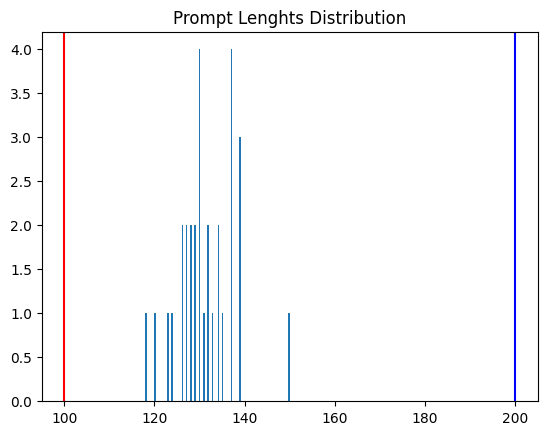

In [113]:
# Tokenize each prompt
import matplotlib.pyplot as plt

lens = [len(x) for x in tokenized_samples]
plt.hist(lens, bins=100)
plt.title("Prompt Lenghts Distribution")
plt.axvline(100, color="red")
plt.axvline(200, color="blue")


### Prompt [2] Token Lengths Distribution

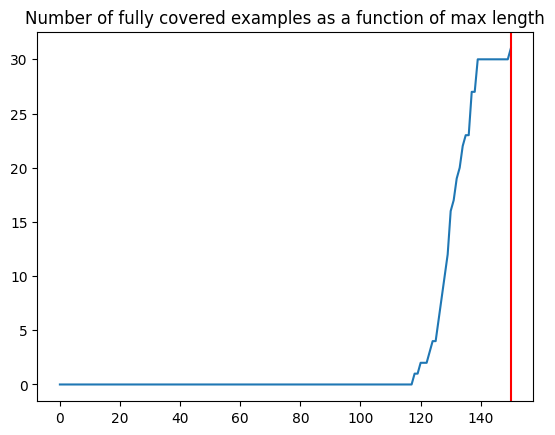

In [116]:
# Plot tokens distributions
plt.plot([len([l for l in lens if l <= m]) for m in range(max(lens) + 1)])
plt.title("Number of fully covered examples as a function of max length")
plt.axvline(x=150, color="red")

### Prompt [3] Min/Max in Tokens

In [ ]:
# Plot percentiles .25 .5 .75


### Coverage [1] Prompt Coverage as a function of Tokens Length

In [ ]:
# Plot gaussian bell

### Coverage [2] Prompt Coverage as a function of hardcoded context size

In [ ]:
# Plot prompts coverage in relation to tokens count

### Word Analysis [1] World Cloud

In [ ]:
# Plot word cloud distribution